Hands-on 머신러닝 책의 2장 내용을 캐글-타이타닉 문제에 맞게 재구성한다. 책의 예제는 주택가격을 예측하는 회귀문제이다. 그러나 타이타닉은 생존자를 예측하는 분류문제다. 따라서 모델 성능 지표를 `ROC 곡선`으로 택한다.

# 1. 데이터 불러오기

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train_test_data = [train, test]

***

# 2. 데이터 전처리

In [59]:
# Sex 전처리
sex_mapping = {"male":0, "female":1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

# SibSp & Parch 전처리
for dataset in train_test_data:
    # 가족수 = 형제자매 + 부모님 + 자녀 + 본인
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    
    # 가족수 > 1이면 동승자 있음
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0

# Embarked 전처리
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)
    
# Name 전처리
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([\w]+)\.', expand=False)

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].apply(lambda x: 0 if x=="Mr" else 1 if x=="Miss" else 2 if x=="Mrs" else 3 if x=="Master" else 4)
    
# Age 결측치 제거
for dataset in train_test_data:
    dataset['Age'].fillna(dataset.groupby("Title")["Age"].transform("median"), inplace=True) 
    
# Fare 결측치 제거
for dataset in train_test_data:
    dataset["Fare"].fillna(dataset.groupby("Pclass")["Fare"].transform("median"), inplace=True)


In [61]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0


***

## 2.1 min-max scaling

`min-max scaling`은 데이터의 크기를 0~1 사이로 조절한다. 내용과 코드에 대한 설명은 아래 링크를 참조하자.

[min-max 스케일링](https://romanticq.github.io/%EC%BA%90%EA%B8%80/kaggle-titanic2/#11-age--min-max-%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81)

In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for dataset in train_test_data:
    array = dataset['Age'].values.reshape(-1,1) # 2D array로 변환
    scaler.fit(array) # 스케일링에 필요한 값(최소값, range 등) 계산
    dataset['AgeScale'] = pd.Series(scaler.transform(array).reshape(-1)) # 스케일링 후 series로 추가

***

## 2.2 standardization

`표준화`는 연속변수를 정규분포의 Z변수에 대응시킨다. 설명은 아래 링크 참조.

[표준화(standarization)](https://romanticq.github.io/%EC%BA%90%EA%B8%80/kaggle-titanic2/#12-fare--%ED%91%9C%EC%A4%80%ED%99%94standardization)

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for dataset in train_test_data:
    array = dataset[['Fare']] # 한 줄짜리 DataFrame
    scaler.fit(array)
    dataset['FareScale'] = pd.Series(scaler.transform(array).reshape(-1))

`min-max 스케일링`과 마찬가지로 array에는 2차원 배열이 저장되어야 한다. `dataset['Fare']`는 series로써 1차원 배열이다. 그러나 `dataset[['Fare']]`는 모양은 똑같아도 Dataframe이다. Dataframe은 그 자체로 2차원 배열에 해당하므로 `fit()` 메서드를 이용할 수 있다.

In [64]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeScale,FareScale
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,0,0.271174,-0.502445
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0,2,0.472229,0.786845
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,0.321438,-0.488854
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0,2,0.434531,0.420730
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,0,0.434531,-0.486337


***

## 2.3 one-hot encoding

one-hot encoding은 하나의 데이터에 하나의 벡터를 대응시키는 변환이다. 대응되는 벡터는 하나의 성분만 1이고 나머지 성분은 0인 n차원 벡터이다. 범주형 데이터를 숫자로 변환할 때 주로 이용한다.

In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
category = train[['Sex','Title']]
onehot = encoder.fit_transform(category)
onehot

<891x7 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

`MinMaxScaler`, `StandardScaler`와 마찬가지로 `OneHotEncoder` 역시 `fit()` 메서드는 2차원 배열을 받는다. 따라서 `category`에 변환하고 싶은 열들만 추려 DataFrame으로 저장한다.  
  
출력 결과는 희소행렬(Sparse matrix)이다. 눈에 보이게끔 하고 싶다면 dataframe으로 바꾸면 된다.

In [32]:
pd.DataFrame(onehot.toarray())

,0,1,2,3,4,5,6
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
886,1.0,0.0,0.0,0.0,0.0,0.0,1.0
887,0.0,1.0,0.0,1.0,0.0,0.0,0.0
888,0.0,1.0,0.0,1.0,0.0,0.0,0.0
889,1.0,0.0,1.0,0.0,0.0,0.0,0.0


위의 예시를 바탕으로 train, test 데이터에 대해 one-hot encoding을 진행한다.

In [62]:
encoder = OneHotEncoder()
train_test_data2=[]

for dataset in train_test_data:
    category = dataset[['Sex', 'Title', 'Embarked', 'IsAlone', 'Pclass']]
    onehot = encoder.fit_transform(category)
    df = pd.DataFrame(onehot.toarray())
    df2 = pd.concat([dataset, df], axis=1)
    train_test_data2.append(df2)

train = train_test_data2[0]
test = train_test_data2[1]

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    int64  
 12  FamilySize   891 non-null    int64  
 13  IsAlone      891 non-null    int64  
 14  Title        891 non-null    int64  
 15  AgeScale     891 non-null    float64
 16  FareScale    891 non-null    float64
 17  0            891 non-null    float64
 18  1            891 non-null    float64
 19  2       

# 3. 모델 선택 & 학습

In [64]:
# 전처리가 끝난 특성들 제거
drop_column = ['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'FamilySize', 'Pclass', 'Sex', 'Title', 'IsAlone', 'Embarked']

train.drop(drop_column, axis=1, inplace=True)
test.drop(drop_column, axis=1, inplace=True)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   AgeScale     891 non-null    float64
 3   FareScale    891 non-null    float64
 4   0            891 non-null    float64
 5   1            891 non-null    float64
 6   2            891 non-null    float64
 7   3            891 non-null    float64
 8   4            891 non-null    float64
 9   5            891 non-null    float64
 10  6            891 non-null    float64
 11  7            891 non-null    float64
 12  8            891 non-null    float64
 13  9            891 non-null    float64
 14  10           891 non-null    float64
 15  11           891 non-null    float64
 16  12           891 non-null    float64
 17  13           891 non-null    float64
 18  14           891 non-null    float64
dtypes: float

In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   AgeScale     418 non-null    float64
 2   FareScale    418 non-null    float64
 3   0            418 non-null    float64
 4   1            418 non-null    float64
 5   2            418 non-null    float64
 6   3            418 non-null    float64
 7   4            418 non-null    float64
 8   5            418 non-null    float64
 9   6            418 non-null    float64
 10  7            418 non-null    float64
 11  8            418 non-null    float64
 12  9            418 non-null    float64
 13  10           418 non-null    float64
 14  11           418 non-null    float64
 15  12           418 non-null    float64
 16  13           418 non-null    float64
 17  14           418 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 58.9 KB


In [68]:
# 훈련을 위한 train, target 분할
drop_column2 = ['PassengerId', 'Survived']
train_data = train.drop(drop_column2, axis=1)
target = train['Survived']

***

## 3.1 k-fold cross-validation

랜덤 포레스트 모델에 대해 k-겹 교차검증을 진행한다. 교차검증에 대한 설명은 아래 링크 참조.

[k-겹 교차검증](https://romanticq.github.io/%EC%BA%90%EA%B8%80/kaggle-titanic2/#3-k-%EA%B2%B9-%EA%B5%90%EC%B0%A8-%EA%B2%80%EC%A6%9Dk-fold-cross-validation--%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%AC)

In [67]:
# 랜덤 포레스트 패키지
from sklearn.ensemble import RandomForestClassifier

# 교차검증 패키지
from sklearn.model_selection import cross_val_predict

`cross_val_predict`는 train 세트에 대해 교차검증을 수행한다. 그러나 `cross_val_score`와 달리 평가점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 각 테스트 폴드의 합은 전체 훈련 세트와 같다. 따라서 교차검증 수행결과 훈련 세트의 모든 샘플에 대해 예측 결과를 얻게 된다.

In [69]:
clf = RandomForestClassifier()
proba_score = cross_val_predict(clf, train_data, target, cv=5, method='predict_proba')
pd.DataFrame(proba_score)

,0,1
0,0.602500,0.397500
1,0.010000,0.990000
2,0.350000,0.650000
3,0.000000,1.000000
4,0.993333,0.006667
...,...,...
886,0.950000,0.050000
887,0.080000,0.920000
888,0.900000,0.100000
889,0.580000,0.420000


## 3.2 모델 평가

In [70]:
# ROC curve 패키지
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

[2.00000000e+00 1.00000000e+00 9.95000000e-01 9.90000000e-01
 9.86067599e-01 9.81666667e-01 9.80000000e-01 9.75086580e-01
 9.70000000e-01 9.60000000e-01 9.52090909e-01 9.51666667e-01
 9.50000000e-01 9.46666667e-01 9.45833333e-01 9.40000000e-01
 9.32000000e-01 9.30000000e-01 9.23333333e-01 9.21666667e-01
 9.20000000e-01 9.10500000e-01 9.10000000e-01 9.06221161e-01
 9.00000000e-01 8.97000000e-01 8.90000000e-01 8.88785714e-01
 8.80000000e-01 8.70809524e-01 8.70000000e-01 8.60000000e-01
 8.54571567e-01 8.50000000e-01 8.47047425e-01 8.40000000e-01
 8.37416084e-01 8.33333333e-01 8.30000000e-01 8.24000000e-01
 8.20000000e-01 8.16515152e-01 8.10000000e-01 7.92166667e-01
 7.90000000e-01 7.80000000e-01 7.70000000e-01 7.69166667e-01
 7.60000000e-01 7.50519120e-01 7.50000000e-01 7.43551759e-01
 7.40000000e-01 7.38500000e-01 7.30000000e-01 7.15000000e-01
 7.00000000e-01 6.90000000e-01 6.80000000e-01 6.70000000e-01
 6.60000000e-01 6.50000000e-01 6.49142857e-01 6.45485570e-01
 6.43333333e-01 6.426284

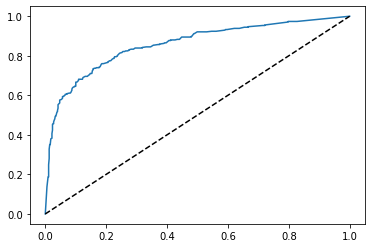

0.8565280840230509

In [79]:
y_score = proba_score[:,1] # 두 번째 열 저장
fpr, tpr, thresholds = roc_curve(target, y_score)

print(thresholds, len(thresholds))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.show()
roc_auc_score(target, y_score)

204개의 임계값에 대해 특이도와 민감도를 계산해서 그린 ROC 곡선이다.

# 4. 모델 파라미터 튜닝

In [80]:
score_list=[]
for i in range(1, 20):
    clf = RandomForestClassifier(max_depth=i, random_state=0, n_jobs=-1)
    y_proba = cross_val_predict(clf, train_data, target, cv=5, method='predict_proba')
    y_score = y_proba[:,1]
    auc = roc_auc_score(target, y_score)
    score_list.append(auc)
    
score_data_frame = pd.DataFrame(score_list, index=range(1, 20))
score_data_frame

,0
1,0.840033
2,0.843069
3,0.847306
4,0.850744
5,0.858717
6,0.862171
7,0.865865
8,0.866533
9,0.869409
10,0.866546


`max_depth` 파라미터를 1~19까지 조절하여 학습시킨 다음 auc를 출력한 결과이다. `max_depth=9` 일때 점수가 가장 높다.

In [81]:
score_list=[]
for i in range(1, 20):
    clf = RandomForestClassifier(max_depth=9, min_samples_leaf=i,random_state=0, n_jobs=-1)
    y_proba = cross_val_predict(clf, train_data, target, cv=5, method='predict_proba')
    y_score = y_proba[:,1]
    auc = roc_auc_score(target, y_score)
    score_list.append(auc)
    
score_data_frame = pd.DataFrame(score_list, index=range(1, 20))
score_data_frame

,0
1,0.869409
2,0.867172
3,0.869529
4,0.867167
5,0.865172
6,0.864075
7,0.860786
8,0.859833
9,0.858437
10,0.856629


 max_depth=9로 고정하고 min과 관련된 변수도 조작해본다. `min_samples_leaf=3`일때 점수가 가장 높으므로 채택한다.

In [82]:
score_list=[]
for i in range(100, 2100, 100):
    clf = RandomForestClassifier(n_estimators=i, max_depth=9, min_samples_leaf=3,random_state=0, n_jobs=-1)
    y_proba = cross_val_predict(clf, train_data, target, cv=5, method='predict_proba')
    y_score = y_proba[:,1]
    auc = roc_auc_score(target, y_score)
    score_list.append(auc)
    
score_data_frame = pd.DataFrame(score_list, index=range(100, 2100, 100))
score_data_frame

,0
100,0.869529
200,0.869777
300,0.870368
400,0.870237
500,0.870679
600,0.870477
700,0.870275
800,0.870328
900,0.870221
1000,0.870413


n_estimators=500일때 점수가 가장 높다. 확정된 파라미터들로 모델을 다시 학습시켜 제출한다.

In [83]:
# 모델 훈련
clf = RandomForestClassifier(n_estimators=500, max_depth=9, min_samples_leaf=3, random_state=0, n_jobs=-1)
clf.fit(train_data, target)
test_data = test.drop("PassengerId", axis=1)
predict = clf.predict(test_data)

# 예측 결과 저장
submission = pd.DataFrame({
    'PassengerId' : test['PassengerId'],
    'Survived' : predict})

submission.to_csv('submission21_forest_n500_max9_min3.csv', index=False)